*Copyright (c) 2023 Graphcore Ltd. All rights reserved.*

$$
\def\br{\mathbf{r}}
\def\bA{\mathbf{A}}
$$

# Integrals over Gaussian Type Orbitals (GTO)

Zooming straight past a number of details, a standard approach in density functional theory (DFT)
is to expand the molecular orbitals $\{\psi_i (\br) \}$ in a finite basis set:
$$
\tag{1}
\psi_i (\br) = \sum_{i=1}^N c_i \phi_i (\br).
$$
Typically the basis functions $\{\phi_i (\br) \}$ are taken as approximations of atomic orbitals and this is referred to as the linear combination of atomic orbitals (LCAO) method in the literature. There is some flexibility in how exactly this finite
basis is defined.  Gaussian type orbitals (GTO) are perhaps
one of the most popular choices and take the following general form 
$$
\tag{2}
\phi_i (\br; \bA, \alpha, l, m, n) = N x_A^l y_A^m z_A^n e^{-\alpha |\br - \bA|^2}.
$$
These functions are parameterised by:
* $\bA = (X_A, Y_A, Z_A)$ is the center of the Gaussian orbital that for our current treatment will be set by the atomic positions of the molecular structure we are simulating. We use the shorthand of $x_A = x - X_A$ in the leading polynomial term
* $\alpha$ in the exponent determines the extent of the Gaussian orbital.
* $(l, m, n)$ are the angular momentum quantum numbers that take on non-negative integer values.
* normalising constant $N$ is a function of $\alpha$ and $(l, m, n)$ and is derived later in this notebook.

Another complication that is worth mentioning up front is that we typically encounter 
*contracted* Gaussian basis functions defined as:
$$
\tag{3}
\phi_i (\br; \bA, l, m, n)  = \sum_{\mu=1}^{K_i} d_{\mu i} p_\mu(\br; \bA, \alpha_\mu, l, m, n)
$$
where we introduce the *primitive* Gaussian:
$$
\tag{4}
p_\mu(\br; \bA, \alpha_\mu, l, m, n) = N x_A^l y_A^m z_A^n e^{-\alpha_\mu |\br - \bA|^2}.
$$
In general the length of the contraction $K_i$ have been pre-optimised alongside the contraction coefficients $d_{\mu i}$ and the primitive exponents $\alpha_\mu$ to best approximate atomic orbitals.  A range of Gaussian basis sets covering the periodic table with different compute time vs accuracy tradeoffs are available from the [basis set exchange](https://www.basissetexchange.org/).  We use their python API in this project to provide programmatic access to these basis sets.

To demonstrate these concepts, we use the `basisset` function to build the atomic orbitals of a single oxygen atom. The `Basis` object built by `basisset` consists of a list of `Orbital` objects which are defined by a set of `coefficients` and corresponding `Primitive` objects.

In [1]:
import numpy as np
from pyscf_ipu.experimental.structure import Structure
from pyscf_ipu.experimental.basis import basisset

basisname = "sto-3g"
oxygen = Structure(atomic_number=np.array([8]), position=np.zeros(3))
basis = basisset(oxygen, basisname)
basis.num_orbitals

5

The number of atomic orbitals follows from the [Aufbau principle](https://en.wikipedia.org/wiki/Aufbau_principle).  Applying this to a single Oxygen atom predicts the electron configuration as $1s^2 2s^2 2p^4$ which keeping in mind that the $2p$ atomic orbitals will consist of three orbitals we arrive at five atomic orbitals for a single oxygen atom.

This rule applies when using a minimal basis set such as `"sto-3g"` which uses a
contraction of 3 Gaussians to approximate each atomic orbital.  From this we expect a tottal of 15 primitives in the basis set for a single oxygen atom:

In [2]:
basis.num_primitives

15

We can plot these atomic orbitals by first evaluating the basis functions on a regular grid and using py3DMol to render isosurfaces.  The $1s$ and $2s$ orbitals have spherical symmetry so we plot the $2px$ orbital below.

In [ ]:
from pyscf_ipu.experimental.mesh import uniform_mesh, molecular_orbitals
from pyscf_ipu.experimental.plot import plot_volume


# Evaluate the molecular orbitals on a mesh -> [num_mesh_points, num_orbitals]
mesh, axes = uniform_mesh(n=32, b=3.0)
orbitals = molecular_orbitals(basis, mesh)
orbitals = np.asarray(orbitals)

# Mapping between orbital label -> index in basis set
orbital_idx = dict(zip(["1s", "2s", "2px", "2py", "2pz"], range(5)))
plot_volume(oxygen, orbitals[:, orbital_idx["2px"]], axes)

$$
\def\br{\mathbf{r}}
\def\bA{\mathbf{A}}
$$

The above visualisation uses the formulas defined earlier to numerically evaluate
each atomic orbital from a linear combintation of primitive Gaussians. Introducing
the basis set allows us to replace the problem of solving a system partial differential equations (e.g. the Kohn-Sham equations) with an algebraic system of equations that can be solved using standard matrix eigenvalue techniques.
The individual elements of the matrices in this system are integrals over pairs of
basis functions:
$$
\tag{5}
M_{ij} = \int \phi_i(\br) \hat{M}(\br) \phi_j(\br) d\br.
$$
We introduce the operator $\hat{M}(\br)$ which in its most general definition is
a function that transforms the $\phi_j(\br)$ basis functions to represent a physical
observable.  That sounds fancy but is just a complicated way of saying we are breaking
down something we can measure (e.g. the energy, dipole moment, etc) into components
that we can evaluate through these integrals.  The simplest operator is simply an 
identity mapping that we name the overlap:
$$
\tag{6}
S_{ij} = \int \phi_i(\br) \phi_j(\br) d\br.
$$
Recalling that each of the atomic orbitals are represented as a linear combination of primitives allows us to further expand the overlap integral as:
$$
\tag{7}
S_{ij} = \int \sum_{\mu = 1}^{K_i} \sum_{\nu = 1}^{K_j} d_{\mu i} d_{\nu j} p_\mu(\br)  p_{\nu}(\br) d\br = \sum_{\mu \nu} d_{\mu i} d_{\nu j} \tilde{S}_{{\mu \nu}}.
$$
Since we can swap the order of integration and the double-summation we are able to introduce $\tilde{S}_{\mu \nu}$ as the elements of the overlap matrix in terms of the primitive functions:
$$
\tag{8}
\tilde{S}_{\mu \nu} = \int p_\mu(\br) p_\nu(\br) d\br.
$$
This finally sets us up to discuss the benefits of using an expansion in Gaussian type orbitals to iteratively solve Kohn-Sham equations using the self-consistent field (SCF) method. As an aside, for a nice overview and derivation of the SCF method we refer the reader to the following review article:

> Lehtola, S., Blockhuys, F. and Van Alsenoy, C., 2020. An overview of self-consistent field calculations within finite basis sets. Molecules, 25(5), p.1218. [open access](https://doi.org/10.3390/molecules25051218)

Gaussian basis functions of the form above have a few convenient properties that help
make it easier to evaluate integrals of the form in equation (5).  To show this
we start by expanding the overlap integral into its full three-dimensional form:
$$
\tag{9}
\tilde{S}_{\mu \nu} = \iiint p_\mu(\br) p_\nu(\br) dx dy dz,
$$
and observing that a primitive $p_\mu(\br)$ can be written as a product of cartesian components:
$$
\tag{10}
p_\mu(\br) = N_\mu
\left(x_A^l e^{-\alpha_\mu x_A^2} \right)
\left(y_A^m e^{-\alpha_\mu y_A^2} \right)
\left(z_A^n e^{-\alpha_\mu z_A^2} \right),
$$
we directly see that we can separate the three-dimensional integral in equation (9) as a
product of three one-dimensional integrals:
$$
\tag{11}
\tilde{S}_{\mu \nu} = N_\mu N_\nu \tilde{S}_{\mu \nu}^{(x)} \tilde{S}_{\mu \nu}^{(y)} \tilde{S}_{\mu \nu}^{(z)}
$$
where we introduce the one-dimensional overlap as
$$
\tag{12}
\tilde{S}_{\mu \nu}^{(x)} = \int_{-\infty}^\infty 
\left(x_A^{l_\mu} e^{-\alpha_\mu x_A^2} \right)
\left(x_B^{l_\nu} e^{-\alpha_\nu x_B^2} \right) dx,
$$
and use the same definition for the y and z components.

By convention each primitive is be normalised such that the "self-overlap" is one, or in other words the diagonal elements of the overlap matrix
will be all ones.
$$
\tag{13}
\tilde{S}_{\mu \mu}  = \int p_\mu(\br)^2 d\br = 1.
$$
rearranging a bit:
$$
\tag{14}
N_\mu = \left( \tilde{S}_{\mu \mu}^{(x)} \tilde{S}_{\mu \mu}^{(y)} \tilde{S}_{\mu \mu}^{(z)} \right)^{-\frac12}.
$$
The one-dimensional self-overlap integral is:
$$
\tag{15}
\tilde{S}_{\mu \mu}^{(x)} = \int_{-\infty}^\infty x^{2l} e^{-2 \alpha_\mu x^2} dx.
$$
We've made use of the translation invariance property of the integral over all $x$ when shifting by the constant $X_A$ in equation (15). 

These one dimensional integrals have a known analytic solution [see equation 42 of gaussian integral](https://mathworld.wolfram.com/GaussianIntegral.html), but we will lean on [SymPy](https://docs.sympy.org/latest/index.html) to help us derive a formula for normalising our primitive Gaussian functions.

In [4]:
import numpy as np
import IPython
from sympy import *

init_printing(use_unicode=True)

In [5]:
a = Symbol("alpha_mu", positive=True, real=True)
k = Symbol("k", integer=True, nonnegative=True)
t, x, y, z = symbols("t x y z", real=True)

self_overlap1d = Integral(t**(2*k) * exp(-2 * a * t**2), (t, -oo, oo))
output = r'\tilde{S}_{\mu \mu} = '
output += latex(self_overlap1d) 
output += ' = '
output += latex(simplify(self_overlap1d.doit()))
IPython.display.Math(output)

<IPython.core.display.Math object>

In [6]:
l,m,n,L = symbols("l m n L", integer=True, nonnegative=True)
sx = self_overlap1d.subs(k, l)
sy = self_overlap1d.subs(k, m)
sz = self_overlap1d.subs(k, n)
self_overlap = sx * sy * sz

self_overlap_expanded = simplify(self_overlap.doit()).subs(l+m+n, L)
output = r'N_\mu^2 = '
output += latex(self_overlap) 
output += ' \quad = \quad \Large '
output += latex(self_overlap_expanded)
IPython.display.Math(output)

<IPython.core.display.Math object>

We can use SymPy to generate a python function that uses the [gamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gamma.html) function from scipy

In [7]:
f = lambdify((l,m,n, a), self_overlap_expanded, modules="scipy")
help(f)

Help on function _lambdifygenerated:

_lambdifygenerated(l, m, n, alpha_mu)
    Created with lambdify. Signature:
    
    func(l, m, n, alpha_mu)
    
    Expression:
    
    (1/(2*alpha_mu))**(L + 3/2)*gamma(l + 1/2)*gamma(m + 1/2)*gamma(n + 1/2)
    
    Source code:
    
    def _lambdifygenerated(l, m, n, alpha_mu):
        return ((1/2)/alpha_mu)**(L + 3/2)*gamma(l + 1/2)*gamma(m + 1/2)*gamma(n + 1/2)
    
    
    Imported modules:



This implementation isn't quite right since it doesn't correctly substitute that $L=l+m+n$ but this
is close enough to allow us to return our attention back to the general overlap elements in equation (11).  To make progress we start by rewriting the product of two
Gaussian functions as a single Gaussian:
$$
\tag{16}
e^{-\alpha (x - a)^2} e^{-\beta (x - b)^2} = 
e^{-\alpha \beta (a - b)^2 / \gamma} e^{-\gamma (x - c)^2}, \\
\gamma = \alpha + \beta \\
c = \frac{\alpha a + \beta b}{\gamma}
$$
Next we rewrite the product of the leading polynomial terms in terms of the Gaussian product center $c$:
$$
\tag{17}
(x - a)^i (x - b)^j = (x - c + c - a)^i (x - c + c - b)^j = (x_c + c_a)^i (x_c + c_b)^j,
$$
where introduce
$$
\tag{18}
x_c = x - c\\
c_a = c - a\\
c_b = c - b.
$$
There isn't a universal term that covers the product of binomial expansions that we have arrived at in equation (17),
and using the [binomial theorem](https://en.wikipedia.org/wiki/Binomial_theorem) we have:
$$
\tag{19}
(x_c + c_a)^i = \sum_{k=0}^i \binom{i}{k} x_c^{i-k} c_a^k \\ 
(x_c + c_b)^j = \sum_{l=0}^j \binom{j}{l} x_c^{j-l} c_b^l 
$$

$$
\tag{20}
(x_c + c_a)^i (x_c + c_b)^j = \sum_{k=0}^i \sum_{l=0}^j \binom{i}{k} \binom{j}{l}  x_c^{i-k} x_c^{j-l} c_a^k c_b^l 
$$
we can use SymPy to help us take the product of these expansions for some representative values of $i$ and $j$

In [8]:
x, a, b = symbols("x_c, c_a, c_b", real=True)
i, j = symbols("i, j", nonnegative=True, integers=True)
poly_terms = (x + a)**i * (x + b) **j
poly_terms

In [9]:
from itertools import product


# output monomial terms with ascending orders x^n, n=0, 1, 2, ...
output = r"\begin{align*}"
for ival, jval in product(range(3), range(3)):
    p = simplify(expand(poly_terms.subs(i, ival).subs(j, jval)))
    output += f"(a + x)^{ival} (b + x)^{jval} &= "
    output += " + ".join(
        [latex(p.coeff(x, n) * x**n) for n in range(ival + jval + 1)]
    )
    output += r"\\"

output += r"\end{align*}"
IPython.display.Latex(output)

<IPython.core.display.Latex object>

By using the symmetry properties of the binomial expansion we can rewrite the terms in the series of Equation (20) as:
$$
\tag{21}
\binom{i}{k} \binom{j}{l}  x_c^{i-k} x_c^{j-l} c_a^k c_b^l  = \binom{i}{k} \binom{j}{l} x_c^k x_c^l c_a^{i-k} c_b^{j-l}.
$$
Recognising that we want to collect terms of same power $x_c^s$ we introduce the constraint that $k+l=s$ allows us to
write the terms as:
$$
\tag{22}
\binom{i}{s-l} \binom{j}{l} x_c^s c_a^{i-(s-l)} c_b^{j-l}.
$$
Replacing the summation variable $l=0, 1,\cdots, j$ with $t$ and incorporating the constraint we arrive at:
$$
\tag{23}
(x_c + c_a)^i (x_c + c_b)^j = 
\sum_{s = 0}^{i+j} x_c^s 
\sum_{\substack{t=0 \\ s - i \le t \le j}}^s 
\binom{i}{s-t} \binom{j}{t} c_a^{i-(s-t)} c_b^{j-t},
$$
Finally we can write this series as:
$$
\tag{24}
(x_c + c_a)^i (x_c + c_b)^j = \sum_{s = 0}^{i+j} B(i, j, c_a, c_b, s) x_c^s,
$$
where we introduce $B(i, j, c_a, c_b, s)$ as the coefficient of $x^s$ in the expansion:
$$
\tag{25}
B(i, j, c_a, c_b, s) = \sum_{\substack{t=0 \\ s - i \le t \le j}}^s \binom{i}{s-t} \binom{j}{t} c_a^{i - (s - t)} c_b^{j-t}
$$
An evaluation strategy for this variable-sized loop is explored in an accompanying [notebook](./binom_factor_table.ipynb).

Combining this result with the one we derived earlier for the product of two
Gaussian functions Equation 16 gives us:
$$
\tag{26}
\tilde{S}_{\mu \nu}^{(x)} = \int_{-\infty}^\infty 
\left(x_A^{l_\mu} e^{-\alpha_\mu x_A^2} \right)
\left(x_B^{l_\nu} e^{-\alpha_\nu x_B^2} \right) dx = \\
\int_{-\infty}^\infty 
 e^{-\alpha_\mu \alpha_\nu (X_A - X_B)^2 / \gamma} e^{-\gamma x_C^2}
\sum_{s=0}^{l_\mu+ l_\nu} B(l_\mu, l_\nu, CA_x, CB_x, s) x_C^s dx
$$
Swapping the order of integration and the summation we see that we need to evaluate
integrals of the form:
$$
\tag{27}
\int_{-\infty}^\infty t^s e^{-a t^2}  dt
$$
This has a known analytic solution that we can evaluate using SymPy:

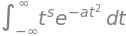

In [10]:
s = symbols("s", nonnegative=True, integer=True)
a = symbols("a", positive=True, real=True)
t = symbols("t", real=True)

gint = Integral(t ** s* exp(-a * t**2), (t, -oo, oo))
gint

In [11]:
expand(gint.doit())

Written this way we can observe that whenever $s$ is odd, the integral will be zero.

In [12]:
v = symbols("v", nonnegative=True, integer=True, odd=True)
gint.subs(s, v).doit()

when $s$ is even we have:

In [13]:
simplify(gint.subs(s, 2*s).doit())

This result can also be written in terms of the [double factorial](https://en.wikipedia.org/wiki/Double_factorial#Additional_identities) which gives us two possible computation strategies for this integral:
$$
\tag{28}
G(a, s) = \int_{-\infty}^{\infty} t^{2s} e^{-a t^2} dt \\
= a^{-s - \frac{1}{2}} \Gamma\left(s + \frac{1}{2}\right) \\
= \frac{(2s-1)!!}{(2a)^s} \sqrt{\frac{\pi}{a}}.
$$
The last form agrees with Equation (3.15) derived by [Fermann and Valeev](http://arxiv.org/abs/2007.12057).

Using the function $G(a, s)$ allows us to write the one-dimensional overlap integral as:
$$
\tilde{S}_{\mu \nu}^{(x)} = 
e^{-\alpha_\mu \alpha_\nu (X_A - X_B)^2 / \gamma}
\sum_{s=0}^{\lfloor(l_\mu + l_\nu)/2 \rfloor} B(l_\mu, l_\nu, CA_x, CB_x, 2s)\;G(\gamma, 2s)
$$
substituting this back into Equation (11) gives us the overlap of two primitive Gaussians:
$$
\tag{11}
\tilde{S}_{\mu \nu} = \iiint p_\mu(\br) p_\nu(\br) dx dy dz \\
= N_\mu N_\nu e^{-\alpha_\mu \alpha_\nu |\mathbf{A}-\mathbf{B}|^2 / \gamma}
\sum_{s=0}^{\lfloor(l_\mu + l_\nu)/2 \rfloor} B(l_\mu, l_\nu, CA_x, CB_x, 2s)\;G(\gamma, 2s) \\
\times \sum_{s=0}^{\lfloor(m_\mu + m_\nu)/2 \rfloor} B(m_\mu, m_\nu, CA_y, CB_y, 2s)\;G(\gamma, 2s)
\sum_{s=0}^{\lfloor(n_\mu + n_\nu)/2 \rfloor} B(n_\mu, n_\nu, CA_z, CB_z, 2s)\;G(\gamma, 2s)
$$